In [2]:
%matplotlib nbagg
#import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools import *
from alvra_tools.channels import *

#from alvra_tools.channels_raw import *

In [3]:
scan_name = "RuBpy3_monoscan_015"

DIR = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

#DIR = "/das/work/p17/p17983/Example_data/raw/scan_data/" + scan_name + "/"
#DIR_json = "/das/work/p17/p17983/Example_data/res/scan_info/"


!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)


total 496G
drwxrwsr-x. 62 17983 p17983 4.0K Jul 26 06:44 ..
-rw-r--r--.  1 17983 p17983 5.9G Jul 26 06:44 RuBpy3_monoscan_015_step0000.JF02T09V02.h5
-rw-r--r--.  1 root  p17983  34K Jul 26 06:44 RuBpy3_monoscan_015_step0000.BSREAD_CA.h5
-rw-r--r--.  1 17983 p17983 7.9G Jul 26 06:44 RuBpy3_monoscan_015_step0000.JF06T32V01.h5
-rw-r--r--.  1 17983 p17983 5.9G Jul 26 06:45 RuBpy3_monoscan_015_step0001.JF02T09V02.h5
-rw-r--r--.  1 17983 p17983 7.9G Jul 26 06:45 RuBpy3_monoscan_015_step0001.JF06T32V01.h5
-rw-r--r--.  1 root  p17983  40K Jul 26 06:45 RuBpy3_monoscan_015_step0001.BSREAD_CA.h5
-rw-r--r--.  1 root  p17983 100M Jul 26 06:45 RuBpy3_monoscan_015_step0000.BSREAD.h5
-rw-r--r--.  1 17983 p17983 5.9G Jul 26 06:46 RuBpy3_monoscan_015_step0002.JF02T09V02.h5
-rw-r--r--.  1 17983 p17983 7.9G Jul 26 06:46 RuBpy3_monoscan_015_step0002.JF06T32V01.h5
-rw-r--r--.  1 root  p17983  39K Jul 26 06:46 RuBpy3_monoscan_015_step0002.BSREAD_CA.h5
-rw-r--r--.  1 root  p17983 100M Jul 26 06:46 RuBpy3_mono

ra-c-003.psi.ch
There are 144 files in the folder /sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_015/


# Load one step and filter some data from I0

In [4]:
f ="RuBpy3_monoscan_015_step0000.BSREAD.h5"
fn = DIR + f

DataFEL_t, DataFEL_f, IzeroFEL, Laser, Variable, PulseIDs = load_FEL_scans(fn, channel_energy)

IzeroFEL_original = IzeroFEL.copy()
print (np.median(IzeroFEL))# - 2*(np.std(IzeroFEL_pump_shot)))

conditionMax = IzeroFEL < np.median(IzeroFEL)+3*(np.std(IzeroFEL))
conditionMin = IzeroFEL > np.median(IzeroFEL)-3*(np.std(IzeroFEL))

conditionGeneral = IzeroFEL > 0

IzeroFEL = IzeroFEL[conditionMin & conditionMax & conditionGeneral]
#IzeroFEL = [x for x in IzeroFEL if (np.abs(x) > 1000)]

0.05702892504632473


<IPython.core.display.Javascript object>


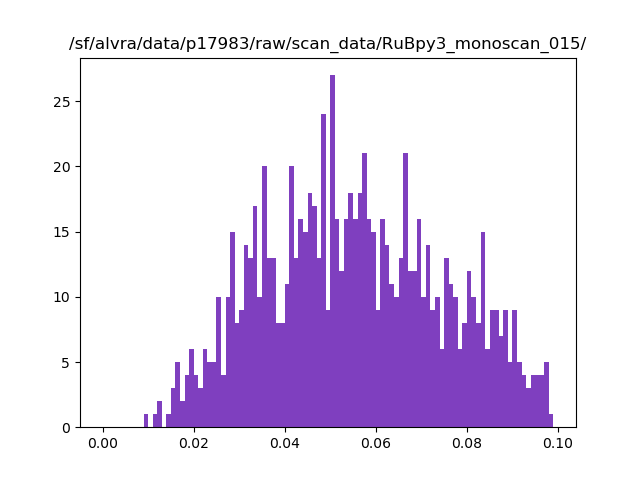

1000 989


In [5]:
#num_bins = 100
plt.figure()
plt.hist(IzeroFEL_original, bins =np.arange(0,0.1,0.001), facecolor='red', alpha=0.5)
plt.hist(IzeroFEL, bins =np.arange(0,0.1,0.001), facecolor='blue', alpha=0.5)
#plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)

plt.title(DIR)
plt.show()
print (IzeroFEL_original.size, IzeroFEL.size)

# Load mono scan

In [10]:
scan_name = "Ru_foil_monoscan_003"          # you need to change only this name

######################################################################################

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

DataFluo = []
DataTrans = []
err_DataFluo = []
err_DataTrans = []
Energy_eV = []

clock = Clock()
print("\nProcessing", numFiles, "files total")

for i in range(0,numFiles):             
    fn_BS = str(data['scan_files'][i][0])    
    exists = os.path.isfile(fn_BS)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        DataFEL_trans, DataFEL_fluo, IzeroFEL, Laser, energy_shot, PulseIDs = load_FEL_scans(fn_BS, channel_energy)
        
        threshold_Izero = IzeroFEL > 0.0001
        
        conditionMax = IzeroFEL < np.median(IzeroFEL)+3*(np.std(IzeroFEL))
        conditionMin = IzeroFEL > np.median(IzeroFEL)-3*(np.std(IzeroFEL))
              
        DataFEL_trans = DataFEL_trans[threshold_Izero & conditionMax & conditionMin]
        DataFEL_fluo = DataFEL_fluo[threshold_Izero & conditionMax & conditionMin]
        IzeroFEL = IzeroFEL[threshold_Izero & conditionMax & conditionMin]
        
        DataFEL_trans_norm = DataFEL_trans / IzeroFEL
        DataFEL_fluo_norm = DataFEL_fluo / IzeroFEL
        
        DataFluo.append(DataFEL_fluo_norm.mean())
        DataTrans.append(DataFEL_trans_norm.mean())
        
        err_DataFluo.append(DataFEL_fluo_norm.std()/np.sqrt(DataFEL_fluo_norm.size))
        err_DataTrans.append(DataFEL_trans_norm.std()/np.sqrt(DataFEL_trans_norm.size))
            
        energy_shot = [x for x in energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_shot))
    
DataFluo = np.asarray(DataFluo)
DataTrans = np.asarray(DataTrans)
err_DataFluo = np.asarray(err_DataFluo)
err_DataTrans = np.asarray(err_DataTrans)
            
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")


/sf/alvra/data/p17983/res/scan_info/Ru_foil_monoscan_003_scan_info.json

Processing 36 files total
step 1 of 36 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_003/Ru_foil_monoscan_003_step0000.BSREAD.h5
step 2 of 36 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_003/Ru_foil_monoscan_003_step0001.BSREAD.h5
step 3 of 36 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_003/Ru_foil_monoscan_003_step0002.BSREAD.h5
step 4 of 36 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_003/Ru_foil_monoscan_003_step0003.BSREAD.h5
step 5 of 36 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_003/Ru_foil_monoscan_003_step0004.BSREAD.h5
step 6 of 36 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_003/Ru_foil_monoscan_003_step0005.BSREAD.h5
step 7 of 36 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_003/Ru_foil_monoscan_003_step0006.BSREAD.h5
step 8 of 36 : Processing /sf/alvra/data

# Plot energy scans

<IPython.core.display.Javascript object>


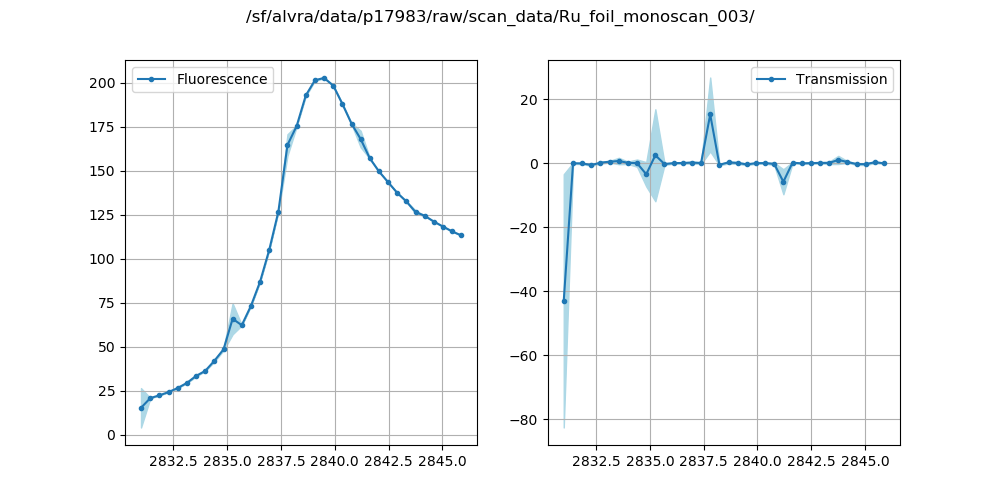

In [11]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1
#plt.title(DIR,horizontalalignment='right')

low_err_Fluo = DataFluo - err_DataFluo
high_err_Fluo = DataFluo + err_DataFluo
low_err_Trans = DataTrans - err_DataTrans
high_err_Trans = DataTrans + err_DataTrans

plt.subplot(1,2,1)
plt.plot(Energy_eV, DataFluo, label="Fluorescence",marker='.')
plt.fill_between(Energy_eV, scale*low_err_Fluo, scale*high_err_Fluo, color='lightblue')
plt.legend(loc="best")
plt.grid()

plt.subplot(1,2,2)
plt.plot(Energy_eV, DataTrans, label="Transmission",marker='.')
plt.fill_between(Energy_eV, scale*low_err_Trans, scale*high_err_Trans, color='lightblue')
plt.legend(loc="best")
plt.grid()

plt.show()

# Summing scans

## Plotting sumed scans